<h1>Data Munging of OpenStreetMaps data - Hyderabad, India</h1> 

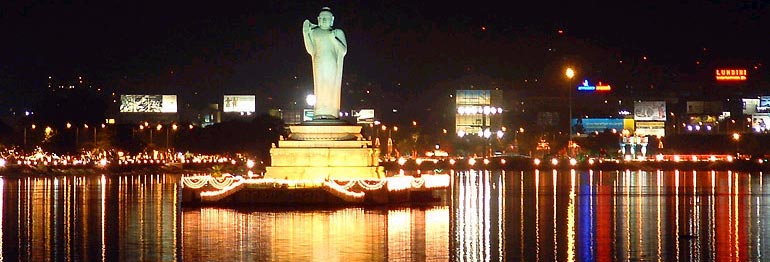

In [1]:
from IPython.display import Image
Image("F:/Anaconda/Scripts/Data_Wrangling/hyderabad_india.jpg")



Home to the world famous biryani and the topic for my data wrangling with MongoDB - Hyderabad!

After downloading my dataset from MapZen URL.The whole file is around 731MB which is too large for my computer to process. Hence, I have sampled the dataset to 83MB to carry out the data munging process.




In [2]:
OSM_FILE = 'HYD_OSM.osm'

To audit the osm file, first we need to know the overview of the data. To get an overview of the data, we count the tag content of the data. I ran it against the mapparser.py to get to the unique number of tags.

In [3]:
# %load mapparser.py
#!/usr/bin/env python

import xml.etree.ElementTree as ET
import pprint

def count_tags(filename):
    """count tags in filename."""
    tags = {}
    for ev,elem in ET.iterparse(filename):
        tag = elem.tag
        if tag not in tags.keys():
            tags[tag] = 1
        else:
            tags[tag]+=1
    return tags

pprint.pprint(count_tags(OSM_FILE))

{'member': 1367,
 'nd': 407095,
 'node': 322802,
 'osm': 1,
 'relation': 227,
 'tag': 86311,
 'way': 77012}


Exploring tag values in the file

In [4]:
# %load tags.py
#!/usr/bin/env python
import xml.etree.ElementTree as ET
import pprint
import re


lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    """ 
    Count the criteria in dictionary for the content of the tag.
    """
    if element.tag == "tag":
        if lower.search(element.attrib['k']):
            keys['lower'] +=1
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon']+=1
        elif problemchars.search(element.attrib['k']):
            keys['problemchars']+=1
        else:
            keys['other']+=1
        
    return keys



def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys



def test():
    # You can use another testfile 'map.osm' to look at your solution
    # Note that the assertions will be incorrect then.
    keys = process_map(OSM_FILE)
    pprint.pprint(keys)



if __name__ == "__main__":
    test()

{'lower': 85790, 'lower_colon': 488, 'other': 29, 'problemchars': 4}


The "k" value of each tag contain different patterns. Using tags.py which has 3 regular expressions to check for certain patterns in the tags. 
The three patterns will check for Lower-case patterns and which are valid. We have 85790 of them.
The second pattern checks for lower case with colon values, we have 488 of them.
We have 4 values which have problem characters which can include '?/!/#' etc.
We have 29 other tags that don't fall into any of these categories.

In [5]:
85790# %load users.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-
import xml.etree.ElementTree as ET
import pprint
import re

def get_user(element):
    return


def process_map(filename):
    """
    Count the user id in the filename.
    """
    users = set()
    for _, element in ET.iterparse(filename):
        try:
            users.add(element.attrib['uid'])
        except KeyError:
            continue

    return users


def test():

    users = process_map(OSM_FILE)
    #pprint.pprint(users)
#     assert len(users) == 6



if __name__ == "__main__":
    test()

Now, Lets check the street names of the various areas in Hyderabad, India

After auditing the file initially, I see that most of the problematic areas have been resolved except for the first address where the place name starts with a comma. 
Using string.punctuation to remove any unnecessary punctuations marks from the addresses!

Another address which i found to wrong was 'Sikh Road, Old Bowenpally;nr Market Yard, Sikh Road, Radha Swamy Colony, Bowenpally,' => here the semicolon shows that they have to separated but when i checked on wiki both the places pointed to the same location hence, I joined them together into one address!



In [6]:
# %load audit.py
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import string
import pprint
from optparse import OptionParser

mycnt = 5
regex = re.compile(r'\b\S+\.?', re.IGNORECASE)

expected = ["Hyderabad", "Road", "Gunj", "Nagar", "Junction", "Hills", "Society"] #expected names in the dataset

mapping = {"hyderabad": "Hyderabad",
            "Nr.": "NR",
           "nr": "NR",
           "Ave.": "Avenue",
           "sbk": "SBK",
           "gandhi": "Gandhi",
           "bridge": "Bridge",
           "road": "Road",
           "Ft.": "Feet",
           "ft": "Feet",
           "Rd": "Road",
           "Rd.": "Road",
           "Rd,": "Road,",
           "rd": "Road",
           "Roads": "Road",
           "society": "Society",
           "soc.": "Society",
           "jn" : "Junction",
           "Jn." : "Junction",
           "Jn" : "Junction"                     
            }

# Search string for the regex. If it is matched and not in the expected list then add this as a key to the set.
def audit_street(street_types, street_name): 
    m = regex.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem): # Check if it is a street name
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile): # return the list that satify the above two functions
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    #tree = ET.parse(osm_file)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street(street_types, tag.attrib['v'])
                    
  
    return street_types

def findWholeWord(w): #Some street names have double occurance 
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

#pprint.pprint(dict(audit(OSM_FILE))) # print the existing names

def string_case(s): # change string into titleCase except for UpperCase
    if s.isupper():
        return s
    else:
        return s.title()

# return the updated names
def update_name(name, mapping):
    name = name.split(' ')
    for i in range(len(name)):
        if name[i] in mapping:
            name[i] = mapping[name[i]]
            name[i] = string_case(name[i])
        elif name[i] in string.punctuation:
            name[i] = name[i].replace(',','')
        elif re.match('[^;\s]+', name[i]): 
            name[i] = name[i].split(';',1)[-1]
        else:
            name[i] = string_case(name[i])
    name = ' '.join(name)
    
# Further cleaning the address strings 
    if ('Sikh Road,') in name:
            name = name.replace('Sikh Road,','').replace('  ','').rstrip(',')
    elif name.startswith(","):
        name = name.replace(',','',1)
    elif name.startswith(" "):
        name = name.replace(' ','')
    elif name.endswith(","): 
            name = name.replace(',','')
    else:
        name = string_case(name)
      
    return name

unmodified_list = []
modified_list = []
# print the updated names
update_street = audit(OSM_FILE) 
for street_type, ways in update_street.iteritems():
    for name in ways:
        better_name = update_name(name, mapping)
        unmodified_list.append(name)
        modified_list.append(better_name)
        #print name, "=>", better_name  

        
print "Before updating =>",unmodified_list[:4]         
print "After updating =>",modified_list[:4]

Before updating => [', Jubilee Enclave-Hitech City', 'Jubilee Hills', 'S.R.Nagar', 'Golnaka Road']
After updating => ['JubileeEnclave-HitechCity', 'Jubilee Hills', 'S.R.Nagar', 'Golnaka Road']


In [7]:
!pip install cerberus
!pip install schema

In [8]:
# %load schema.py

schema = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}

In [9]:
# %load data.py
#!/usr/bin/env python
import csv
import codecs
import re
import xml.etree.cElementTree as ET
import pprint

import cerberus


from audit import update_name, is_street_name

OSM_PATH = 'HYD_OSM.osm'

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  
    if element.tag == 'node':
        for attrib in element.attrib:
            if attrib in NODE_FIELDS:
                node_attribs[attrib] = element.attrib[attrib]
                
        for child in element:
            node_tag = {}
            if LOWER_COLON.match(child.attrib['k']):
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = child.attrib['v']
                node_tag['type'] = child.attrib['k'].split(':',1)[0]
                node_tag['key'] = child.attrib['k'].split(':',1)[1]
                tags.append(node_tag)
            
            elif PROBLEMCHARS.match(child.attrib['k']):
                 continue
            else:
                node_tag['type'] = 'regular'
                node_tag['key']  = child.attrib['k']
                node_tag['value'] = child.attrib['v']
                node_tag['id'] = element.attrib['id']
                tags.append(node_tag)
        
        return {'node': node_attribs, 'node_tags': tags}
    
    elif element.tag == 'way':
        for attrib in element.attrib:
            if attrib in WAY_FIELDS:
                way_attribs[attrib] = element.attrib[attrib]
            
        pos = 0
        for child in element:
            way_tags = {}
            way_node = {}
            
            if child.tag == 'tag':
                if LOWER_COLON.match(child.attrib['k']):
                    way_tags['id'] = element.attrib['id']
                    way_tags['value'] = child.attrib['v']
                    way_tags['type'] = child.attrib['k'].split(':',1)[0]
                    way_tags['key'] = child.attrib['k'].split(':',1)[1]
                    tags.append(way_tags)
                elif PROBLEMCHARS.match(child.attrib['k']):
                    continue
                    
                else:
                    way_tags['type'] = 'regular'
                    way_tags['key']  =  child.attrib['k']
                    way_tags['value'] = child.attrib['v']
                    way_tags['id'] = element.attrib['id']
                    tags.append(way_tags)
                
            elif child.tag == 'nd':
                way_node['id'] = element.attrib['id']
                way_node['node_id'] = child.attrib['ref']
                way_node['position'] = pos
                pos +=1
                way_nodes.append(way_node)
                
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    data = process_map(OSM_PATH, validate=True)

, Jubilee Enclave-Hitech City => Jubilee Enclave-Hitech City
Jubilee Hills => Jubilee Hills
S.R.Nagar => S.R.Nagar
Golnaka Road => Golnaka Road
tellapur road => Tellapur Road
Balanagar Cross Road => Balanagar Cross Road
BN Reddy Nagar => Bn Reddy Nagar
manage rd => Manage Road
Saraswathi nagar colony => Saraswathi Nagar Colony
Liberty Road => Liberty Road
Dhoolpet Road => Dhoolpet Road
Beside Pranam Hospital => Beside Pranam Hospital
R.C.Puram => R.C.Puram
EFLU => EFLU
B-73 apie, IDA, Balanagar, Hyderabad, => B-73 Apie, Ida, Balanagar, Hyderabad,
Jai jawan colony => Jai Jawan Colony
sathyanarayana Puram Road => Sathyanarayana Puram Road
Gautham Nagar => Gautham Nagar
Harinagar Main Road,  Marinatha Church => Harinagar Main Road,  Marinatha Church
Miyapur => Miyapur
Opp Parda Gate King Koti Road => Opp Parda Gate King Koti Road
dammaiguda => Dammaiguda
baddam balreddy nagar => Baddam Balreddy Nagar
Cherlapalli Industrial Area => Cherlapalli Industrial Area
Madhuranagar Main Road => Madh

In [10]:
import xml.etree.ElementTree as ET
import pprint
import re
import codecs
import json


lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
addresschars = re.compile(r'addr:(\w+)')
CREATED = [ "version", "changeset", "timestamp", "user", "uid"]
OSM_FILE = 'HYD_OSM.osm'

def shape_element(element):
    #node = defaultdict(set)
    node = {}
    if element.tag == "node" or element.tag == "way" :
        #create the dictionary based on exaclty the value in element attribute.
        node = {'created':{}, 'type':element.tag}
        for k in element.attrib:
            try:
                v = element.attrib[k]
            except KeyError:
                continue
            if k == 'lat' or k == 'lon':
                continue
            if k in CREATED:
                node['created'][k] = v
            else:
                node[k] = v
        try:
            node['pos']=[float(element.attrib['lat']),float(element.attrib['lon'])]
        except KeyError:
            pass
        
        if 'address' not in node.keys():
            node['address'] = {}
        #Iterate the content of the tag
        for stag in element.iter('tag'):
            #Init the dictionry

            k = stag.attrib['k']
            v = stag.attrib['v']
            #Checking if indeed prefix with 'addr' and no ':' afterwards
            if k.startswith('addr:'):
                if len(k.split(':')) == 2:
                    content = addresschars.search(k)
                    if content:
                        node['address'][content.group(1)] = v
            else:
                node[k]=v
        if not node['address']:
            node.pop('address',None)
        #Special case when the tag == way,  scrap all the nd key
        if element.tag == "way":
            node['node_refs'] = []
            for nd in element.iter('nd'):
                node['node_refs'].append(nd.attrib['ref'])
#         if  'address' in node.keys():
#             pprint.pprint(node['address'])
        return node
    else:
        return None


def process_map(file_in, pretty = False):
    """
    Process the osm file to json file to be prepared for input file to monggo
    """
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

def test():

    data = process_map(OSM_FILE)
    print("success")
    #pprint.pprint(data[500])
    #print(data[0:6])

if __name__ == "__main__":
    test()

success


The processed map has ben saved to hyd_sample_new.osm.json Now that we have process the audited map file into array of JSON, let's put it into mongodb instance. this will take the map that we have been audited. First we load the script to insert the map

Okay let's test if the data is something that we expect

In [11]:
#data = process_map('hyderabad_india.osm',True)
#print(data[0:6])

The data seems look good. Now, let's put it into MongoDB

In [12]:
def get_db():
    """
    Creates a connection to a MongoDB that contains the imported clean data

    Args: None

    Returns: The wdw collection from the openstreet database

    """
    from pymongo import MongoClient

    client = MongoClient('localhost:27017')

    db = client.hyd_osm.hyd

    return db

# The JSON file was imported into MongoDB via the command line.  This will store the db for use with Python.
db_hyd = get_db()

In [13]:
#number of documents inserted
db_hyd.find().count() 

399814

<H2> Data Overview and Additional Ideas

This section describes the data statistics, the file size and the details about the contributors of this dataset at OpenStreetMap.

<h4>File Size </h4>

<h4> Number of Unique Users:


In [14]:
len(db_hyd.distinct('created.user'))

579

<h4>Number of Nodes

In [15]:
len(list(db_hyd.find({"type": "node"})))


322802

<h4>Number of Ways

In [16]:
len(list(db_hyd.find({"type": "way"})))

77012

<h3>Show 5 users with their street names

In [17]:
pipeline = [{'$match': {'address.street':{'$exists':1}}},{"$project":{"_id" : 0 ,"username":"$created.user","address":"$address.street"}}, {'$limit' : 5}]
result  = db_hyd.aggregate(pipeline,useCursor=False)
pprint.pprint(list(result))


[{u'address': u'Gautham Nagar', u'username': u'Yellajosyula Satish'},
 {u'address': u'Malkajgiri', u'username': u'Yellajosyula Satish'},
 {u'address': u'Liberty Road', u'username': u'thednr83'},
 {u'address': u'Rd No 2, Banjara Hills', u'username': u'NiteshSingh'},
 {u'address': u'Barkatpura', u'username': u'dannykath'}]


<h3>Top 10 contributing Users

In [18]:
pipeline = [
            {'$match': {'created.user':{'$exists':1}}},
            {'$group': {'_id':'$created.user',
                        'count':{'$sum':1}}},
            {'$sort': {'count':-1}},
            {'$limit' : 10}
]
result  = db_hyd.aggregate(pipeline,useCursor=False)
pprint.pprint(list(result))

[{u'_id': u'himabindhu', u'count': 14474},
 {u'_id': u'saikumar', u'count': 13185},
 {u'_id': u'bindhu', u'count': 12935},
 {u'_id': u'anushapyata', u'count': 12185},
 {u'_id': u'venkatkotha', u'count': 12147},
 {u'_id': u'Apreethi', u'count': 11957},
 {u'_id': u'anthony1', u'count': 11494},
 {u'_id': u'harisha', u'count': 11064},
 {u'_id': u'masthanvali', u'count': 10777},
 {u'_id': u'udaykanth', u'count': 9042}]


<h3> What type of address do we have?

In [19]:
list(db_hyd.distinct("shop"))

[u'supermarket',
 u'mall',
 u'convenience',
 u'car',
 u'department_store',
 u'electronics',
 u'bakery',
 u'alcohol',
 u'music',
 u'clothes',
 u'hairdresser',
 u'books',
 u'confectionery',
 u'motorcycle',
 u'yes',
 u'travel_agency',
 u'variety_store',
 u'cosmetics',
 u'mobile_phone',
 u'medical_supply',
 u'stationery',
 u'gift',
 u'butcher',
 u'copyshop',
 u'optician',
 u'sports',
 u'car_repair']

<h3> List of all the confectionery shops

In [20]:
pipeline = [
            {'$match': {'shop':'confectionery',
                        'name':{'$exists':1}}},
            {'$project':{'_id':'$name',
                          'contact':'$phone'}}
]
result  = db_hyd.aggregate(pipeline,useCursor=False)
pprint.pprint(list(result))

[{u'_id': u"Dadu's Mithai Vatika"},
 {u'_id': u'Mathwalle Doodh Falloda and Lassi'},
 {u'_id': u'Agarwala sweets'}]


<h2> Other Ideas to improve reliability/accuracy of OSM datasets 

While exploring the OpenStreetMap site, I noticed that there is no restriction as to who controls the data being inputed into their database. Anyone could go online; add their data which at first seems very good. But like every coin has two sides, this also means that anyone could also input wrong information!

While exploring my dataset, using <b>Mapwel</b> I saw that there were a lot of nodes from the center of city but that's probably because that's where all the participating users are from! That means, the data present isn't exactly a true representation of the city. Hence, this explained why I couldn't find many places listed when I tried to project some of them using the above the codes. We could try improving the <b>gamification</b> i.e., increasing the user participation using a <u><b>Reward system</b></u> where more the data contributed, more number of points.
We can make OSM contributions like a game, where each user who contributes gets a point. With increasing points, the user steps up levels like any other games we play on PS or Xbox! 

But since this could backfire, we need to set up another function where once the user checks-in the particular address, this function would validate the address with Google Maps for the accuracy and then only update the OSM database.





<h2> Conclusion


After this review of the data it’s obvious that the hyderabad area is incomplete and some of the addresses are inaccurate! I think they should develop a function which regularly checks the input made by the users. Like it always anticipated that human entered data is bound to have errors and with so many GPS softwares using OpenStreetMap.org it's really important for them to generate error free maps. 